In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import preprocessing
import datetime as dt
%matplotlib inline

In [2]:
data=pd.read_csv("Data.V7.csv", index_col="Date")

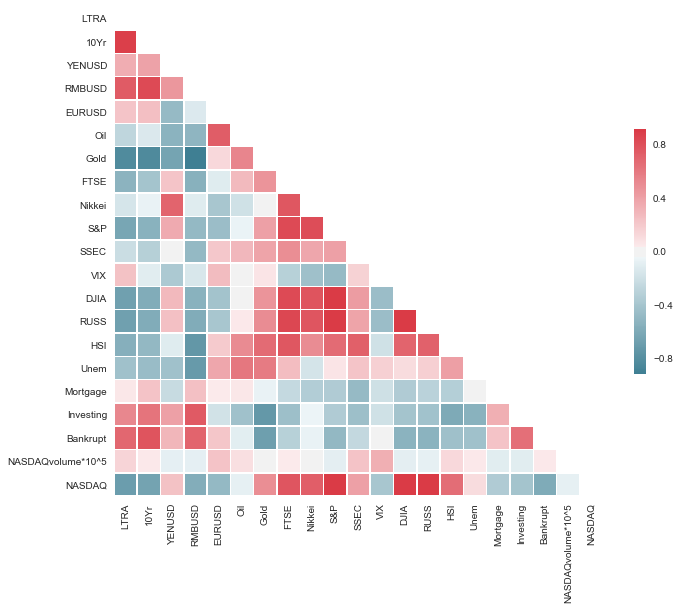

In [3]:
sns.set(style="white")
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [4]:
Val1=['LTRA', '10Yr', "RMBUSD",'EURUSD']
Val2=['Unem','Mortgage', 'Investing', 'Bankrupt']
Val3=['YENUSD','Oil','VIX']
Val4=['S&P','Gold','RUSS','NASDAQ']
Val5=['DJIA', 'HSI','Nikkei','FTSE','SSEC',"NASDAQvolume*10^5"]

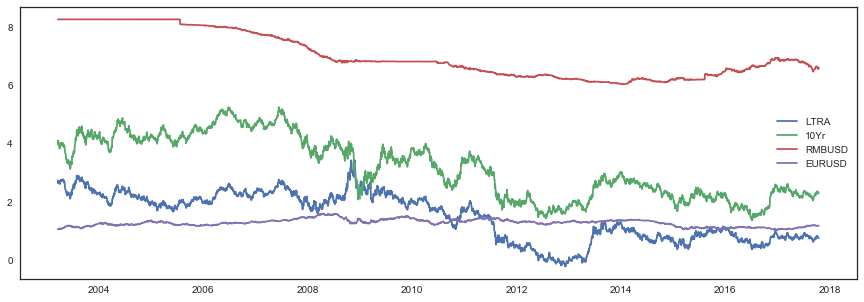

In [5]:
plt.figure(figsize=(15,5))
for i in Val1:
    plt.plot([dt.datetime.strptime(d,'%Y-%m-%d').date() for d in data.index],data[i].values, label=i)
plt.legend(loc="best")

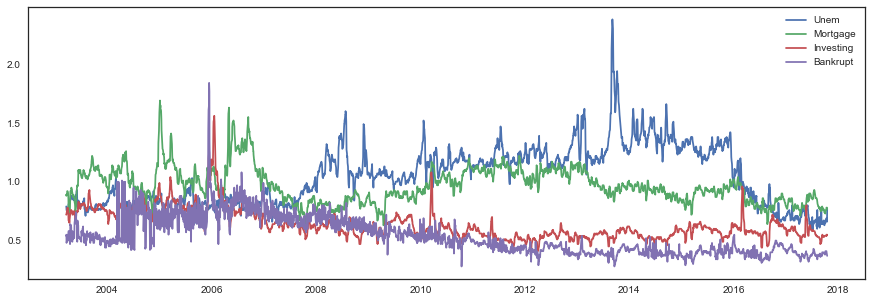

In [6]:
plt.figure(figsize=(15,5))
for i in Val2:
    plt.plot([dt.datetime.strptime(d,'%Y-%m-%d').date() for d in data.index],data[i].values, label=i)
plt.legend(loc="best")

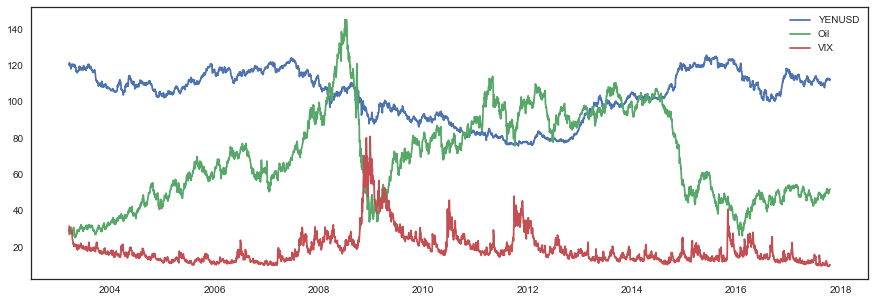

In [7]:
plt.figure(figsize=(15,5))
for i in Val3:
    plt.plot([dt.datetime.strptime(d,'%Y-%m-%d').date() for d in data.index],data[i].values, label=i)
plt.legend(loc="best")

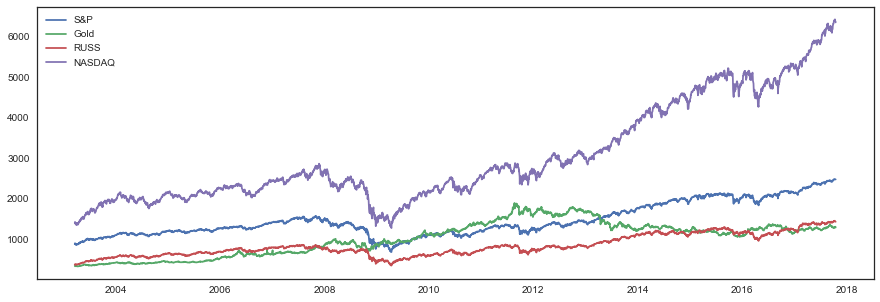

In [8]:
plt.figure(figsize=(15,5))
for i in Val4:
    plt.plot([dt.datetime.strptime(d,'%Y-%m-%d').date() for d in data.index],data[i].values, label=i)
plt.legend(loc="best")

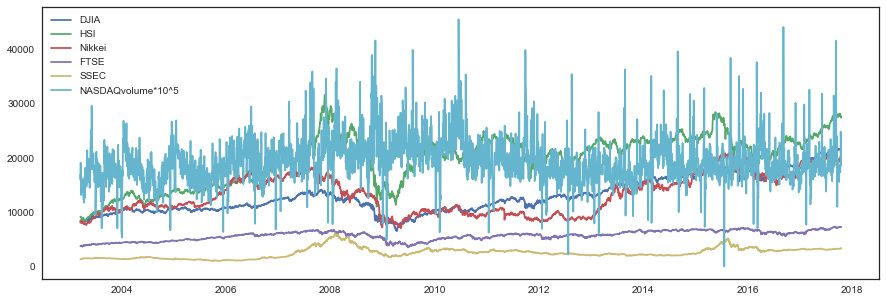

In [9]:
plt.figure(figsize=(15,5))
for i in Val5:
    plt.plot([dt.datetime.strptime(d,'%Y-%m-%d').date() for d in data.index],data[i].values, label=i)
plt.legend(loc="best")

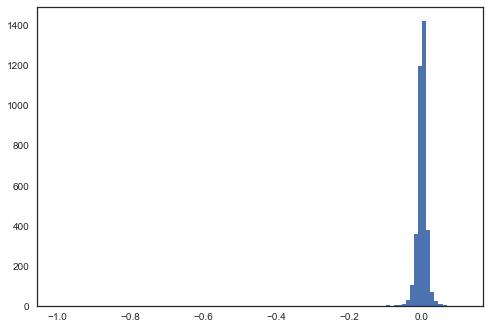

In [10]:
NASDAQLogreturn=[-1] #set the first value to -1 to align dataframe
temp=data["NASDAQ"].values
for i in range(1,len(temp)):
    NASDAQLogreturn.append(np.log(temp[i]/temp[i-1]))
data["NASDAQLogreturn"]=pd.Series(NASDAQLogreturn, index=data.index)
plt.hist(data["NASDAQLogreturn"], bins=100);

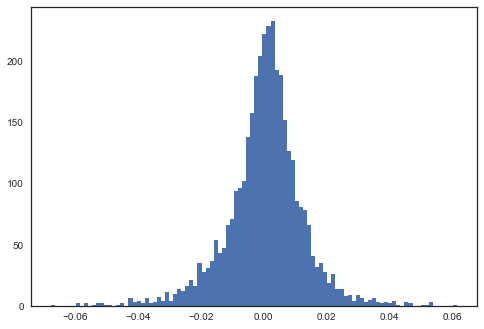

In [11]:
ReturnNoExtreme=sorted(data["NASDAQLogreturn"])[5:-5]
plt.hist(ReturnNoExtreme, bins=100);

In [12]:
# divide NASDAQ into up state(1) and down state(-1)
ret = data["NASDAQLogreturn"]
class_today = ret.copy()
class_today[ret >= 0] = 1
class_today[ret < 0] = -1

In [13]:
data["NASDAQ_class_today"] = class_today
data["NASDAQ_class_nextday"] = class_today.shift(-1)
data["NASDAQLogreturn_nextday"] = ret.shift(-1)
data.dropna(inplace=True)

In [14]:
data["NASDAQ_class_nextday"].value_counts()

 1.0    1987
-1.0    1630
Name: NASDAQ_class_nextday, dtype: int64

## Linear logistic regression using all features

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

n_train = 3000
train_data = data.iloc[:n_train, :]
test_data = data.iloc[n_train:, :]

X_train = train_data.iloc[:, :-5]
y_train = train_data.iloc[:, -2]
X_test = test_data.iloc[:, :-5]
y_test = test_data.iloc[:, -2]

# Use standardization to scale the input sample X in training set and use the same scaler to scale the testing set
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use cross validation to find the best regularization strength
tuned_parameters = [{"C":np.linspace(0.001, 0.1, 100).tolist()}]
score = 'recall'


print("# Tuning hyper-parameters for %s" % score)
print()
clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=5, scoring='%s_macro' % score)
clf.fit(X_train_scaled, y_train)
print("Best parameters set found on development set:")
print()
C = clf.best_params_['C']
print(C)

logreg = LogisticRegression(C=C)

logreg.fit(X_train_scaled,y_train)

predict_class = logreg.predict(X_test_scaled)

accuracy = logreg.score(X_test_scaled, y_test)
print("prediction accuracy of linear logistic regression: ", accuracy)

# Tuning hyper-parameters for recall

Best parameters set found on development set:

0.010000000000000002
prediction accuracy of linear logistic regression:  0.560777957861


# Feature Selection by LASSO

We can use LASSO to select the features, and use feature to predict the next day's logreturn of NASDAQ index, then to judge the change of NASDAQ index.

In [19]:
n_train = 3000
train_data = data.iloc[:n_train, :]
test_data = data.iloc[n_train:, :]

X_train = train_data.iloc[:, :-3]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-3]
y_test = test_data.iloc[:, -1]

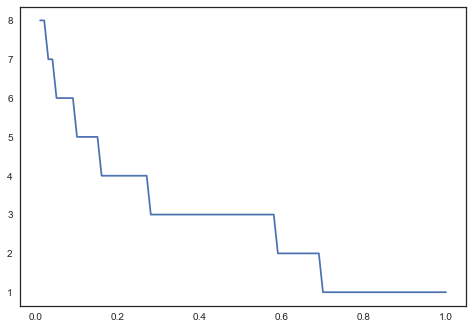

In [20]:
# LASSO
import matplotlib.pyplot as plt
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train, y_train)
num_features = []
alpha = np.linspace(0.01, 1,100)
for a in alpha:
    n = 0
    clf = linear_model.Lasso(alpha = a)
    clf.fit(X_train, y_train)
    for i in clf.coef_:
        if abs(i) > 10**(-20):
            n += 1
    num_features.append(n)
plt.plot(alpha, num_features)

In [21]:
#choose alpha = 0.2, 0.5, 1
#find the features

alpha = [0.01, 0.5, 1]
for a in alpha:
    clf = linear_model.Lasso(alpha = a)
    clf.fit(X_train, y_train)
    features = []
    for i in range(len(clf.coef_)):
        if abs(clf.coef_[i]) > 10**(-20):
            features.append(list(data)[i])
    print('When alpha = ',a,', features has',features)

When alpha =  0.01 , features has ['Gold', 'Nikkei', 'SSEC', 'DJIA', 'RUSS', 'HSI', 'NASDAQvolume*10^5', 'NASDAQ']
When alpha =  0.5 , features has ['DJIA', 'HSI', 'NASDAQvolume*10^5']
When alpha =  1 , features has ['NASDAQvolume*10^5']


So we can find that the changes of NASDAQ depends on other index instead of price of commodities. And the Gold is the only commodity that 'survive' from LASSO and feature selection.

Also, we can find that when we incease the alpha, NASDAQ dissappear before NASDAQ Volume, which means when we predict the changes of NASDAQ index, the volume is more important than NASDAQ price.

And NASDAQ volume is the most important feature.

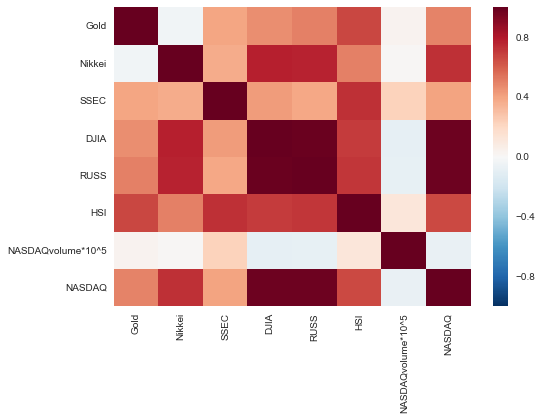

In [22]:
# find correlations of feature
clf = linear_model.Lasso(alpha = 0.01)
clf.fit(X_train, y_train)
features = []
for i in range(len(clf.coef_)):
    if abs(clf.coef_[i]) > 10**(-20):
        features.append(list(data)[i])
corr = data[features].corr()
sns.heatmap(corr)

It seems the correlation of the features are not high. We can apply this features in model. First we can find weather LASSO is a good method for classification.

In [23]:
# choose consider the rate
clf = linear_model.Lasso(alpha = 0.01)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
rate = 0
for i in range(len(X_test)):
    if y_predict[i]*y_test[i] >0:
        rate += 1
rate = rate/len(X_test)
rate

0.539708265802269

Obviously, the LASSO can't be used to predict the changes of NASDAQ.

# Linear Regression in Time Series

In the previous section, it seems the LASSO couldn't be used to predict the time series of stock price. We can check if other linear regression such as ridge could be effective.

In [24]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1)
clf.fit(X_train, y_train) 
y_predict = clf.predict(X_test)
rate = 0
for i in range(len(X_test)):
    if y_predict[i]*y_test[i] >0:
        rate += 1
rate = rate/len(X_test)
rate

0.5089141004862237

The Linear Regression can't be used to predict the return of NASDAQ index.

## Logistic regression using Lasso selected features

In [82]:
n_train = 3000
train_data = data.iloc[:n_train, :]
test_data = data.iloc[n_train:, :]

X_train = train_data.iloc[:, :-3]
y_train = train_data.iloc[:, -2]
X_test = test_data.iloc[:, :-3]
y_test = test_data.iloc[:, -2]

# selected_features = ['Gold', 'Nikkei', 'SSEC', 'DJIA', 'RUSS', 'HSI', 'NASDAQvolume*10^5', 'NASDAQ']
# selected_features = ['DJIA', 'HSI', 'NASDAQvolume*10^5']
selected_features = ['NASDAQvolume*10^5']


X_new_train = X_train.loc[:, selected_features]
X_new_test = X_test.loc[:, selected_features]

# Use cross validation to find the best regularization strength
tuned_parameters = [{"C":np.linspace(0.001, 0.1, 100).tolist()}]
score = 'recall'


print("# Tuning hyper-parameters for %s" % score)
print()
clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=10, scoring='%s_macro' % score)
clf.fit(X_new_train, y_train)
print("Best parameters set found on development set:")
print()
C = clf.best_params_['C']
print(C)

logreg = linear_model.LogisticRegression(C=C)

logreg.fit(X_new_train, y_train)

predict_class = logreg.predict(X_new_test)

accuracy = logreg.score(X_new_test, y_test)
print("prediction accuracy of linear logistic regression: ", accuracy)

# Tuning hyper-parameters for recall

Best parameters set found on development set:

0.001
prediction accuracy of linear logistic regression:  0.551053484603


## RBF SVM using Lasso selected features

In [83]:
from sklearn.svm import SVC
SVM = SVC(kernel = "linear", C=1)
SVM.fit(X_new_train, y_train)
predict_class = SVM.predict(X_new_test)

accuracy = SVM.score(X_new_test, y_test)
print("prediction accuracy of linear logistic regression: ", accuracy)

prediction accuracy of linear logistic regression:  0.551053484603


## Feature selection using Linear SVM with l1 regularizer

In [28]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

n_train = 3000
train_data = data.iloc[:n_train, :]
test_data = data.iloc[n_train:, :]

X_train = train_data.iloc[:, :-3]
y_train = train_data.iloc[:, -2]
X_test = test_data.iloc[:, :-3]
y_test = test_data.iloc[:, -2]

# Use standardization to scale the input sample X in training set and use the same scaler to scale the testing set
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use linear SVM with L1 norm regularizer to select features
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_new_train = model.transform(X_train_scaled)
X_new_test = model.transform(X_test)

X_new_train.shape

(3000, 12)

## RBF SVM using svm selected features

In [29]:
SVM = SVC(kernel = "rbf", C=1)
SVM.fit(X_new_train, y_train)
predict_class = SVM.predict(X_new_test)

accuracy = SVM.score(X_new_test, y_test)
print("prediction accuracy of linear logistic regression: ", accuracy)

prediction accuracy of linear logistic regression:  0.551053484603


## Logistic Regression using svm selected features 

In [31]:

# Use cross validation to find the best regularization strength
tuned_parameters = [{"C":np.linspace(0.001, 0.1, 100).tolist()}]
score = 'recall'


print("# Tuning hyper-parameters for %s" % score)
print()
clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=10, scoring='%s_macro' % score)
clf.fit(X_new_train, y_train)
print("Best parameters set found on development set:")
print()
C = clf.best_params_['C']
print(C)

logreg = linear_model.LogisticRegression(C=C)

logreg.fit(X_new_train,y_train)

predict_class = logreg.predict(X_new_test)

accuracy = logreg.score(X_new_test, y_test)
print("prediction accuracy of linear logistic regression: ", accuracy)

# Tuning hyper-parameters for recall

Best parameters set found on development set:

0.001
prediction accuracy of linear logistic regression:  0.526742301459


## Logistic regression and SVM with Principal Components

In [84]:
from sklearn.decomposition import PCA
pca = PCA(n_components=X_train_scaled.shape[1])
pca.fit(X_train_scaled)

print(pca.explained_variance_ratio_)  


[  4.38045262e-01   1.90567793e-01   1.21337667e-01   6.03273831e-02
   4.55987811e-02   3.85986766e-02   2.17882037e-02   1.79323167e-02
   1.72201530e-02   1.25990074e-02   8.19905442e-03   7.06914374e-03
   6.66950203e-03   4.26531780e-03   3.59891336e-03   2.00231547e-03
   1.94430193e-03   1.04751334e-03   5.36687633e-04   3.54681662e-04
   2.37623663e-04   5.97013436e-05]


In [85]:
sum(pca.explained_variance_ratio_[:7])

0.9162637665855915

In [86]:
X_new_train = pca.transform(X_train_scaled)[:,:7]
X_new_test = pca.transform(X_test_scaled)[:,:7]
SVM = SVC(kernel = "rbf", C=1)
SVM.fit(X_new_train, y_train)
predict_class = SVM.predict(X_new_test)

accuracy = SVM.score(X_new_test, y_test)
print("prediction accuracy of linear logistic regression: ", accuracy)

prediction accuracy of linear logistic regression:  0.551053484603


In [87]:
X_new_train = pca.transform(X_train_scaled)[:,:7]
X_new_test = pca.transform(X_test_scaled)[:,:7]
# Use cross validation to find the best regularization strength
tuned_parameters = [{"C":np.linspace(0.001, 0.1, 100).tolist()}]
score = 'recall'


print("# Tuning hyper-parameters for %s" % score)
print()
clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=10, scoring='%s_macro' % score)
clf.fit(X_new_train, y_train)
print("Best parameters set found on development set:")
print()
C = clf.best_params_['C']
print(C)

logreg = linear_model.LogisticRegression(C=C)

logreg.fit(X_new_train,y_train)

predict_class = logreg.predict(X_new_test)

accuracy = logreg.score(X_new_test, y_test)
print("prediction accuracy of linear logistic regression: ", accuracy)


# Tuning hyper-parameters for recall

Best parameters set found on development set:

0.003
prediction accuracy of linear logistic regression:  0.555915721232


## Classification Visualization

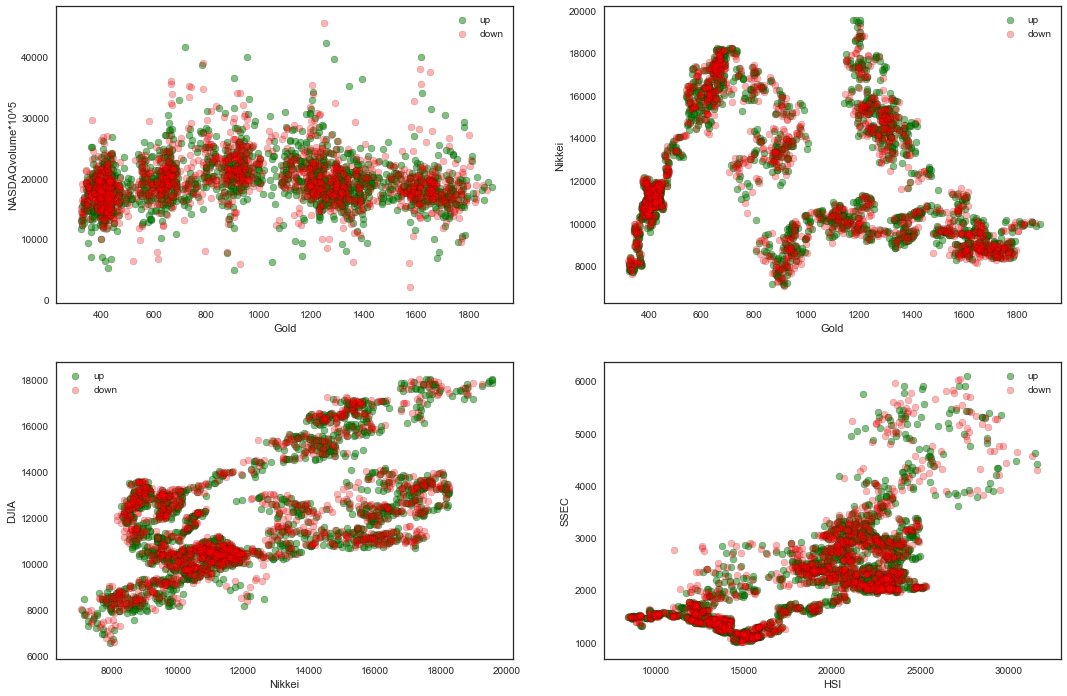

In [97]:
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
fig = plt.figure(figsize=(18,12))
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

n_train = 3000
train_data = data.iloc[:n_train, :]
test_data = data.iloc[n_train:, :]

X_train = train_data.iloc[:, :-3]
y_train = train_data.iloc[:, -2]
X_test = test_data.iloc[:, :-3]
y_test = test_data.iloc[:, -2]

plt.subplot(221)
x = "Gold"
y = "NASDAQvolume*10^5"
plt.scatter(X_train.loc[y_train == 1, x], X_train.loc[y_train == 1, y], 
            c="green", cmap=cm_bright, edgecolors='k',label = "up", alpha = 0.5)
plt.scatter(X_train.loc[y_train == -1, x], X_train.loc[y_train == -1, y], 
            c="red", cmap=cm_bright, edgecolors='k',label = "down", alpha = 0.3)
plt.xlabel(x)
plt.ylabel(y)
plt.legend()

plt.subplot(222)
x = "Gold"
y = "Nikkei"
plt.scatter(X_train.loc[y_train == 1, x], X_train.loc[y_train == 1, y], 
            c="green", cmap=cm_bright, edgecolors='k',label = "up", alpha = 0.5)
plt.scatter(X_train.loc[y_train == -1, x], X_train.loc[y_train == -1, y], 
            c="red", cmap=cm_bright, edgecolors='k',label = "down", alpha = 0.3)
plt.xlabel(x)
plt.ylabel(y)
plt.legend()

plt.subplot(223)
x = "Nikkei"
y = "DJIA"
plt.scatter(X_train.loc[y_train == 1, x], X_train.loc[y_train == 1, y], 
            c="green", cmap=cm_bright, edgecolors='k',label = "up", alpha = 0.5)
plt.scatter(X_train.loc[y_train == -1, x], X_train.loc[y_train == -1, y], 
            c="red", cmap=cm_bright, edgecolors='k',label = "down", alpha = 0.3)
plt.xlabel(x)
plt.ylabel(y)
plt.legend()

plt.subplot(224)
x = "HSI"
y = "SSEC"
plt.scatter(X_train.loc[y_train == 1, x], X_train.loc[y_train == 1, y], 
            c="green", cmap=cm_bright, edgecolors='k',label = "up", alpha = 0.5)
plt.scatter(X_train.loc[y_train == -1, x], X_train.loc[y_train == -1, y], 
            c="red", cmap=cm_bright, edgecolors='k',label = "down", alpha = 0.3)
plt.xlabel(x)
plt.ylabel(y)
plt.legend()